In [25]:
import argparse
import time
import msgpack
import matplotlib.pyplot as plt
import numpy as np
import utm
import random


from planning_utils import a_star, heuristic, create_grid_graph, G_weight, prune_path, closest_point


In [26]:

import networkx as nx
nx.__version__

'2.1'

In [27]:
def local_to_global(local_position, global_home):
    (east_home, north_home, zone_number, zone_letter) = utm.from_latlon(
                                                        global_home[1], global_home[0])
    
    (lat, lon) = utm.to_latlon(east_home + local_position[1],
                               north_home + local_position[0], zone_number,
                               zone_letter)
                               
    global_position = np.array([lon, lat, -(local_position[2]-global_home[2])])
    
    return global_position

In [28]:
TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

lat0, lon0= np.loadtxt('colliders.csv', delimiter=',', dtype='str', usecols = (0,1))[0]
lat0 = float(lat0.split()[1])
lon0 = float(lon0.split()[1])
print (lat0, lon0)

global_position = local_to_global((921, 921, 0), (lon0,lat0, 0))
print (global_position)

random.seed(4)
print (random.uniform(0,100))
# Read in obstacle map
data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

# Define a grid for a particular altitude and safety margin around obstacles
grid, edges, north_offset, east_offset = create_grid_graph(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
print ("Grid size:", grid.shape)


37.79248 -122.39745
[-122.38692131   37.80072673    0.        ]
23.604808973743452
North offset = -316, east offset = -445
Grid size: (921, 921)


In [29]:
import numpy.linalg as LA
G = nx.Graph()
for e in edges:
    p1 = tuple(e[0])
    p2 = tuple(e[1])
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)



In [31]:
grid_goal = (750.0, 370.0)
goal_position = (int(grid_goal[0]+ north_offset),int(grid_goal[1]+ east_offset))
goal_global_position = local_to_global((goal_position[0], goal_position[1], 0), (lon0,lat0, 0))
print (goal_global_position)
goal_g = closest_point(G, grid_goal)
print (goal_g)

grid_start = (326.4054326042533, 455.0057368486887)
start_g = closest_point(G, grid_start)
print (start_g)

[-122.39827005   37.79639587    0.        ]
(748.71871888430212, 364.41446809309031)
(323.76114000000001, 445.76846)


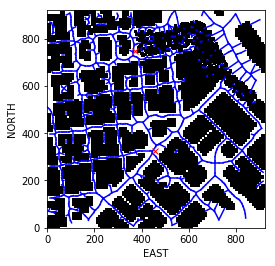

In [32]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(grid_start[1], grid_start[0], 'rx')
plt.plot(grid_goal[1], grid_goal[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [33]:
path, cost = a_star(G, heuristic, start_g, goal_g)
pruned_path = prune_path(path)
pruned_path.append(grid_goal)
pruned_path.insert(0, grid_start)
waypoints = [[int(p[0] + north_offset), int(p[1] + east_offset), TARGET_ALTITUDE, 0] for p in pruned_path]
print (waypoints)
type(waypoints[0][0:3])

Found a path.
[[10, 10, 5, 0], [7, 0, 5, 0], [26, 14, 5, 0], [32, 17, 5, 0], [34, 15, 5, 0], [44, 5, 5, 0], [54, -1, 5, 0], [64, -6, 5, 0], [84, -11, 5, 0], [93, -15, 5, 0], [94, -16, 5, 0], [98, -17, 5, 0], [104, -24, 5, 0], [129, -39, 5, 0], [149, -19, 5, 0], [154, -16, 5, 0], [174, -26, 5, 0], [184, -29, 5, 0], [204, -29, 5, 0], [204, -29, 5, 0], [212, -29, 5, 0], [214, -30, 5, 0], [224, -34, 5, 0], [244, -34, 5, 0], [254, -37, 5, 0], [258, -40, 5, 0], [274, -44, 5, 0], [279, -41, 5, 0], [294, -44, 5, 0], [314, -44, 5, 0], [324, -46, 5, 0], [327, -45, 5, 0], [344, -49, 5, 0], [362, -49, 5, 0], [364, -50, 5, 0], [374, -54, 5, 0], [397, -54, 5, 0], [404, -62, 5, 0], [407, -67, 5, 0], [409, -74, 5, 0], [412, -81, 5, 0], [428, -82, 5, 0], [432, -80, 5, 0], [434, -75, 5, 0]]


list

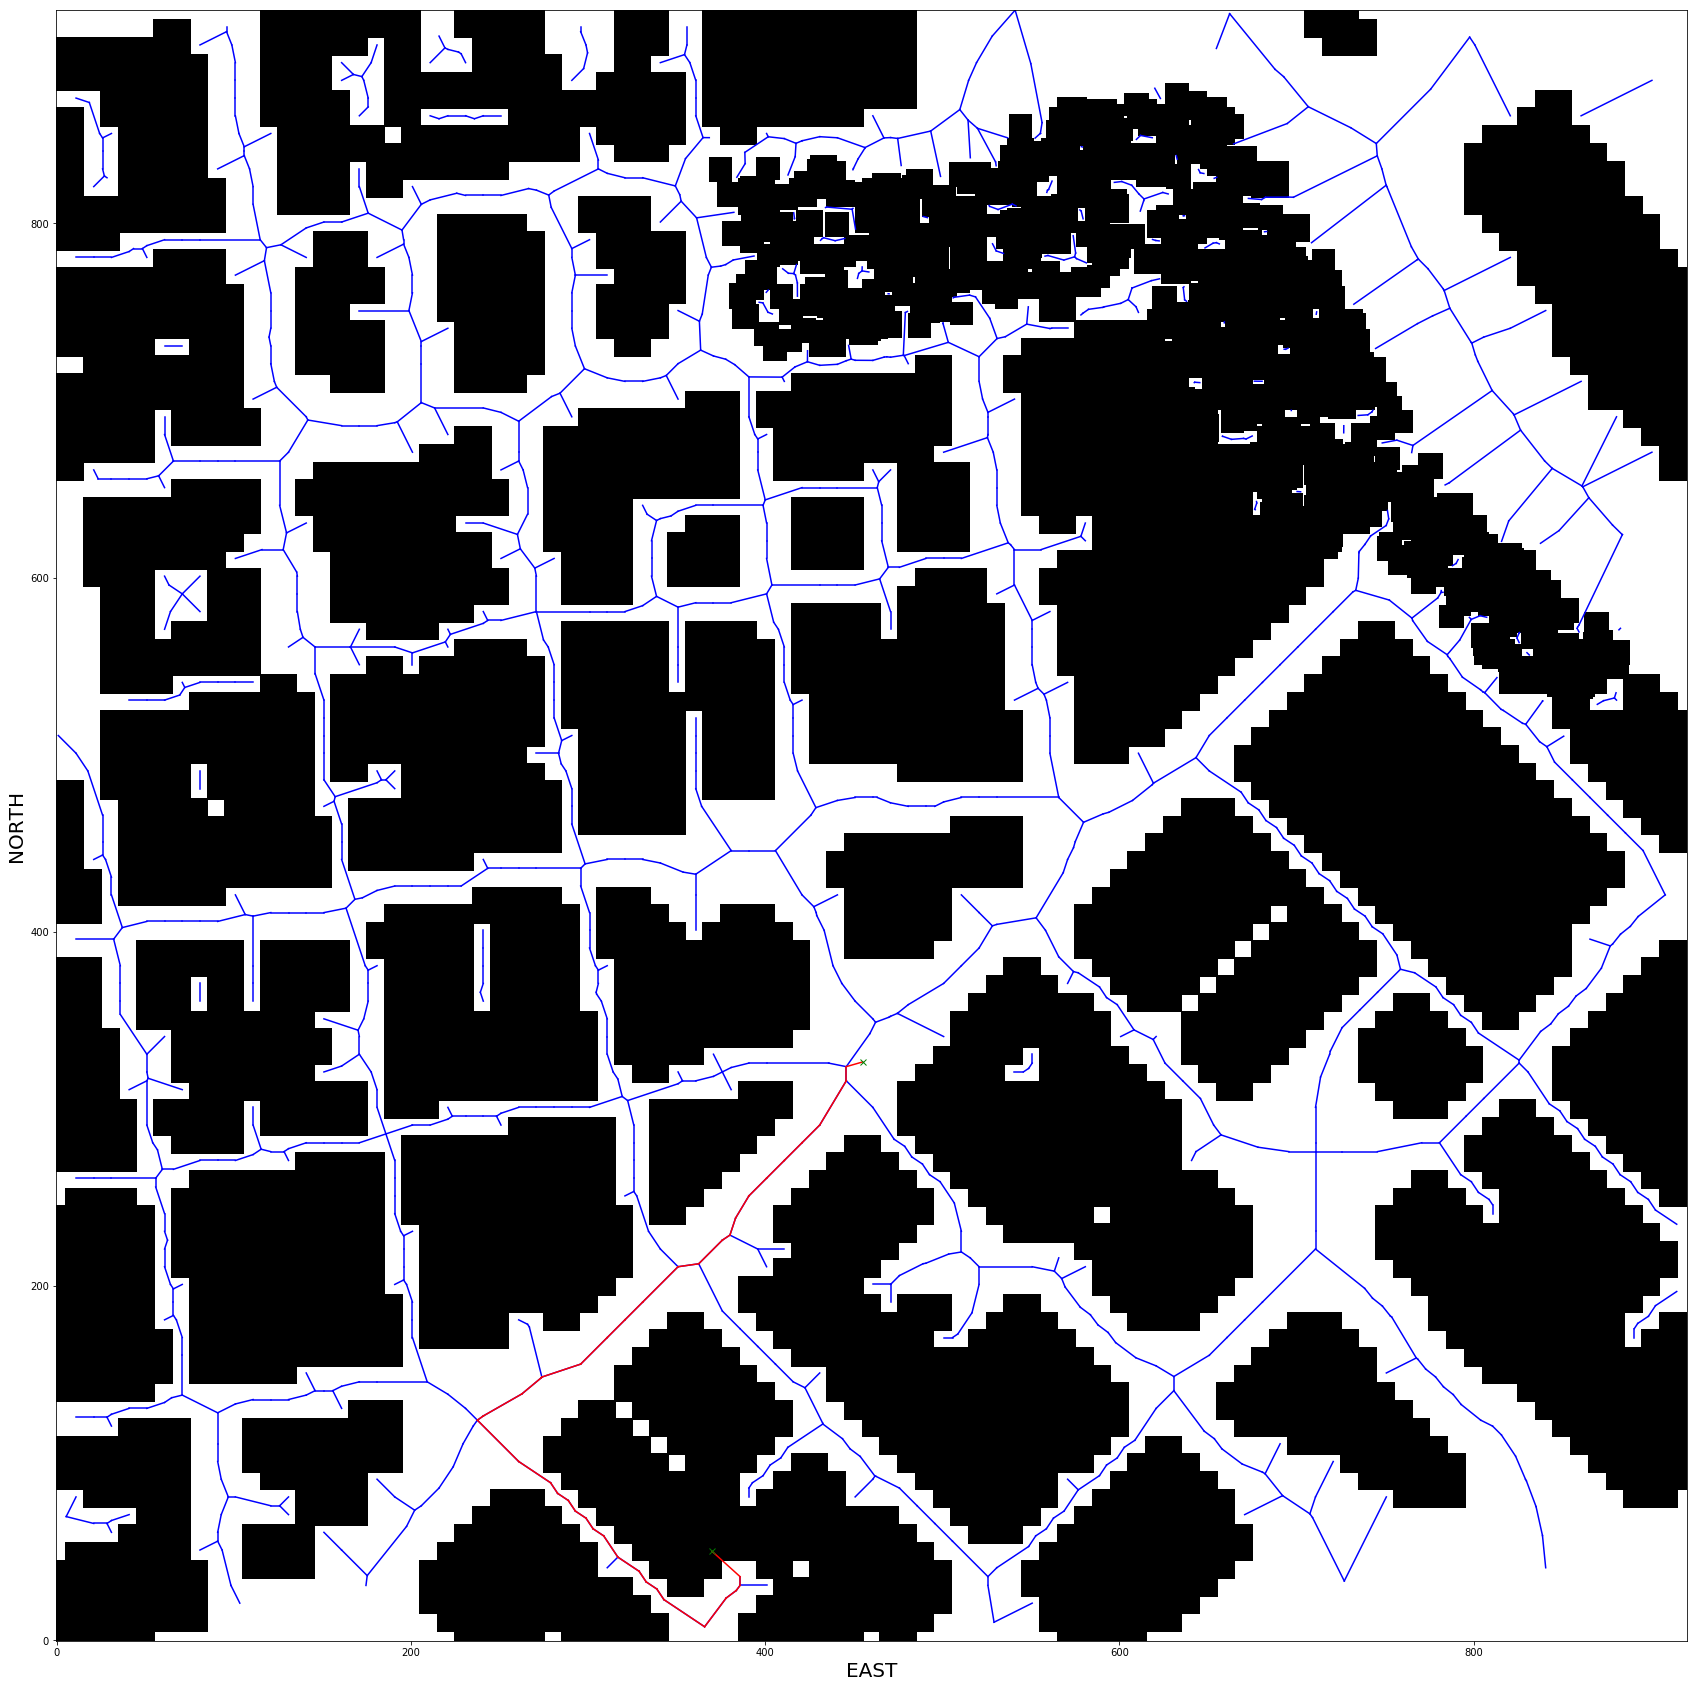

In [24]:
fig1 = plt.figure(figsize = (30,30))
plt.imshow(grid, origin='lower', cmap='Greys') 
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([grid_start[1], start_g[1]], [grid_start[0], start_g[0]], 'r-')
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
plt.plot([grid_goal[1], goal_g[1]], [grid_goal[0], goal_g[0]], 'r-')
    
plt.plot(grid_start[1], grid_start[0], 'gx')
plt.plot(grid_goal[1], grid_goal[0], 'gx')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()